In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from matplotlib import pyplot as plt
import torch

# MNIST Dataset

## Train

AnomalyMNIST Dataset (Number of samples: 7321, Number of known anomalies: 512)


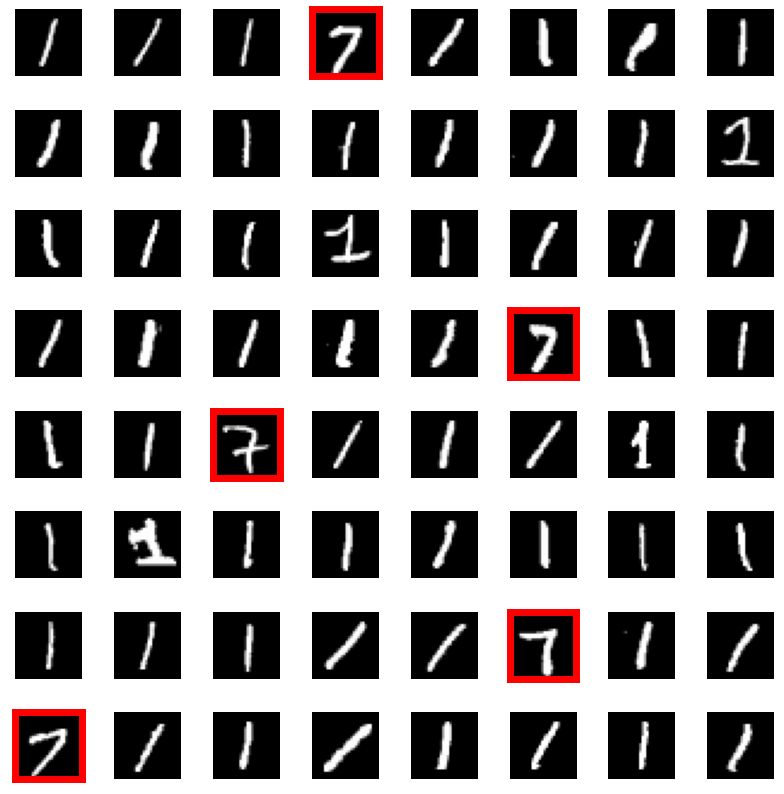

In [2]:
from dataset import AnomalyMNIST
from torchvision.transforms import Normalize,ToTensor, Compose


seed = 64
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
# transform = Compose([ToTensor()])

dataset = AnomalyMNIST('data/', download=True, n_known_anomalies=512, transform=transform, seed=seed)
print(dataset)

dataset.montage(8, 8, seed)
plt.show()

In [3]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

## Test

In [4]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_dataset_full = MNIST('data/', train = False, download = True, transform = transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx[:256], anomaly_idx[:256]]) # 512 samples!

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)
test_loader =  DataLoader(x_test_set, 512, shuffle=False)

Anomaly


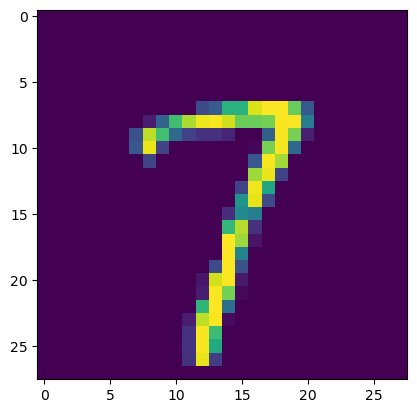

In [5]:
# TO REMOVE! Just testing!
import random
random.seed(64)
random_idx = random.randint(0, 511)
x, y = x_test_set[random_idx]
plt.imshow(x[0])
print('Anomaly' if y == 1 else 'Normal')

# Model

In [6]:
from torch import nn
from VAE.AnomalyDetector import AnomalyDetector
from VAE.utils import SGVBL

class VAE(nn.Module):
    def __init__(self, input_size, latent_space):
        super(VAE, self).__init__()
        conv_out_size = input_size // (2*2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            # nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(32*(conv_out_size**2), 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
        )

        self.botleneck = AnomalyDetector(128, latent_space)

        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 128),
            nn.BatchNorm1d(128),
            # nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 32*(conv_out_size**2)),
            # nn.Dropout(0.2),
            nn.ReLU(),
            nn.Unflatten(1, (32, conv_out_size, conv_out_size)),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
        )


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.botleneck(x)
        x = self.decoder(x)
        return x

model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(dataset), mle=mse_loss)

# Training

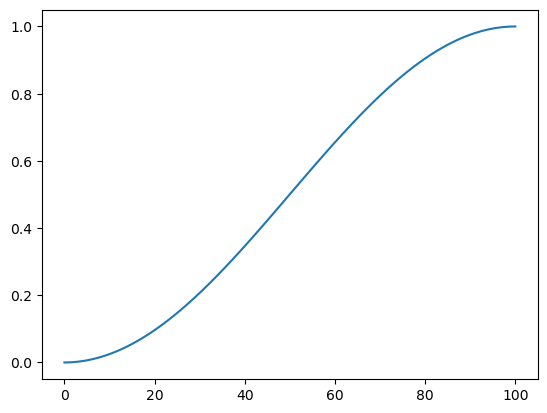

In [7]:
from VAE.utils import cosine_scheduler
plt.plot(cosine_scheduler(100, 1e-3))
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 50

from tqdm import tqdm

epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

# Scheduler for the D_KL(.|.)
# kl_weight = torch.clip(cosine_scheduler(n_epochs), 0, .99)
# kl_weight = cosine_scheduler(n_epochs)

opt = torch.optim.Adam(model.parameters())
for epoch in epoch_iterator:
    epoch_loss = 0.
    for x, y in train_loader:
        # check if there are a target with 1
        # if torch.any(y == 1):
            # print("Anomaly detected")
            # break
        x = x.to(device) # GPU
        opt.zero_grad()
        # x_hat = torch.sigmoid(model(x))
        x_hat = torch.tanh(model(x))
        # loss = sgvbl(x, x_hat, y, kl_weight[epoch])
        loss = sgvbl(x, x_hat, y, 1)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()

    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

100%|██████████| 50/50 [01:31<00:00,  1.84s/epoch, tls=18.425]


In [9]:
mse_loss(x, x_hat)

tensor(0.1303, device='cuda:0', grad_fn=<MseLossBackward0>)

# Result

In [10]:
import numpy as np

def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            z = model.botleneck(model.encoder(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

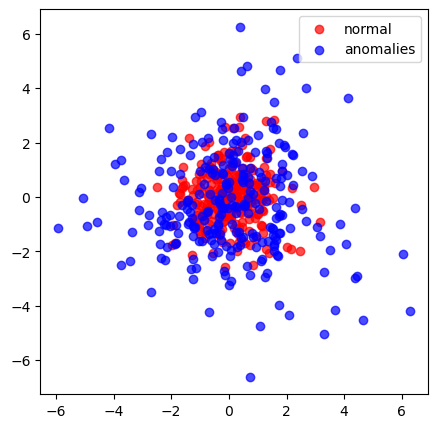

In [12]:
model.eval()
# model.train()
fig = plot_latent(model, test_loader, num_batches=25)
plt.savefig('figures/latent_space_test.png', dpi=300, bbox_inches='tight')

## Sampling normal and anomaly sample

torch.Size([1, 1, 28, 28])


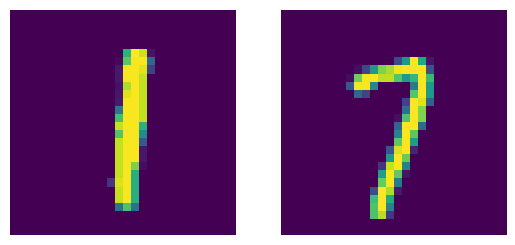

In [13]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[150]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1).squeeze()[152]].unsqueeze(0)

print(x_0.shape)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
plt.axis('off')
plt.savefig('anomalies.png', bbox_inches='tight')

model.eval()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.botleneck(model.encoder(x_0.to(device))).detach().cpu())
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

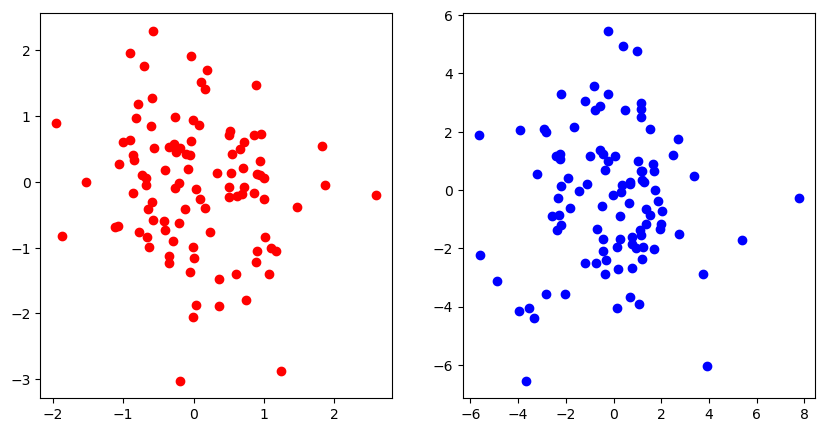

In [14]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')
plt.savefig('figures/anomalies_latent_sample.png', bbox_inches='tight')

In [15]:
x = torch.cat([x_0, x_1]).to(device)
print(x.shape)

model.eval()
with torch.no_grad():
    x_hat = model(x)

model.botleneck.sigma.detach(), model.botleneck.mu.detach()

torch.Size([2, 1, 28, 28])


(tensor([[0.9636, 0.9770],
         [2.0954, 2.1476]], device='cuda:0'),
 tensor([[-3.1398e-05,  1.6017e-05],
         [ 4.3803e-05,  9.7279e-06]], device='cuda:0'))

In [16]:
x_0.shape

torch.Size([1, 1, 28, 28])

## Reconstruction

In [17]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    fig = plt.figure(figsize=(5, 5))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.sigmoid(autoencoder.decoder(z))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('$\mathcal{N}(x;0,\sigma_1)$')
    plt.ylabel('$\mathcal{N}(x;0,\sigma_2)$')
    # plt.axis('off')
    return fig

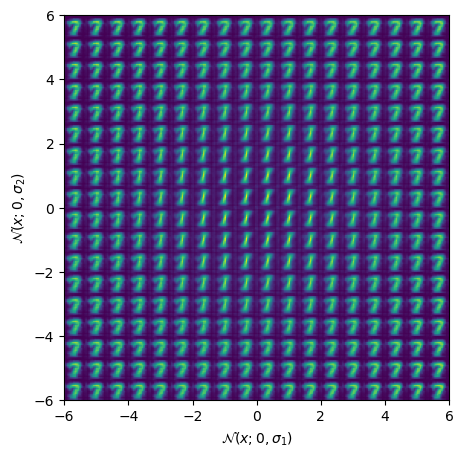

In [20]:
model.eval()
fig = plot_reconstructed(model.to(device), r0=(-6, 6), r1=(-6, 6), n=18)
plt.savefig('figures/reconstructed.pdf', bbox_inches='tight')
plt.show(fig)

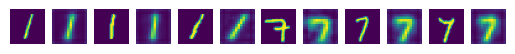

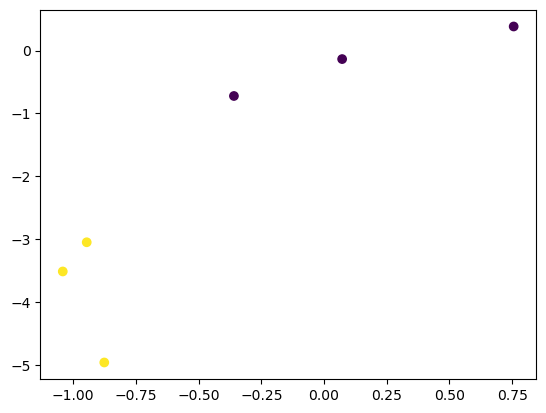

In [20]:
test_idx = torch.linspace(0, 511, 6, dtype=int)
x, y = next(iter(test_loader))
x_hat = torch.sigmoid(model(x.cuda()).detach().cpu())
z = model.botleneck(model.encoder(x.cuda())).detach().cpu()

for i, idx in enumerate(test_idx):
    plt.subplot(1, 2*len(test_idx), 2*(i+1)-1)
    plt.imshow(x[idx, 0])
    plt.axis('off')

    plt.subplot(1, 2*len(test_idx), 2*(i+1))
    plt.imshow(x_hat[idx,0])
    plt.axis('off')

plt.show()

plt.scatter(z[test_idx, 0], z[test_idx, 1], c=y[test_idx] )
plt.show()

## MedMNIST

In [35]:
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [56]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 512
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [57]:

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz


In [58]:
type(test_dataset.labels)

numpy.ndarray

In [59]:
next(iter(test_loader))[0].shape

torch.Size([624, 1, 28, 28])

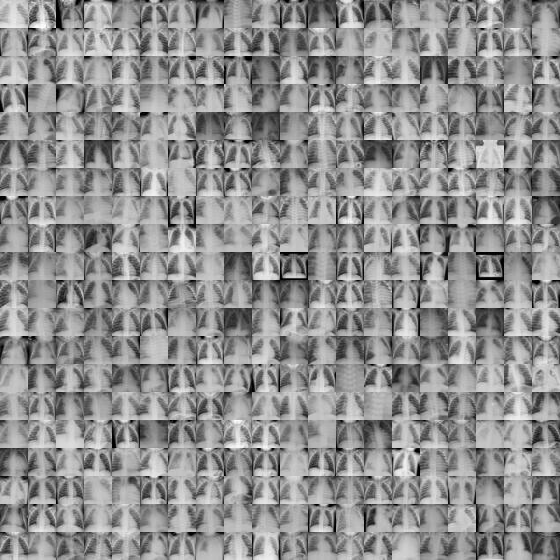

In [60]:
train_dataset.montage(length=20)

In [83]:
import numpy as np
train_dataset.labels
normal_idx = torch.tensor(np.where((train_dataset.labels == 1))[0])
anomaly_idx = torch.tensor(np.where((train_dataset.labels == 0))[0])

idx = torch.cat([normal_idx, anomaly_idx[:512]])

# change labels to 0 and 1, the rest to -1
train_dataset.labels = np.ones_like(train_dataset.labels) * -1
train_dataset.labels[normal_idx] = 0
train_dataset.labels[anomaly_idx] = 1

x_train_set = Subset(train_dataset, idx)
train_loader =  DataLoader(x_train_set, 100, shuffle=True)
# normal_idx = torch.where((dataset_full.targets == 7))[0]
# anomaly_idx = torch.where((dataset_full.targets == 1))[0]

In [84]:
x, y = next(iter(x_train_set))
torch.max(x), torch.min(x) 

(tensor(0.7647), tensor(-1.))

In [85]:
normal_idx.shape, anomaly_idx.shape

(torch.Size([3494]), torch.Size([1214]))

In [86]:
model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), mle=mse_loss)

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100
from tqdm import tqdm
# kl_weight = 0.02

epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

# kl_weight = torch.clip(cosine_scheduler(n_epochs), 0, 0.99)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in epoch_iterator:
    epoch_loss = 0.
    # kl_weight = min(kl_weight+0.012, .9)
    for x, y in train_loader:
        # check if there are a target with 1
        # if torch.any(y == 1):
            # print("Anomaly detected")
            # break
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = torch.tanh(model(x))
        # loss = sgvbl(x, x_hat, y, kl_weight[epoch])
        loss = sgvbl(x, x_hat, y, 1)
        # loss = sgvbl(x, x_hat, y, kl_weight)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()
    
    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

  0%|          | 0/100 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 100/100 [02:16<00:00,  1.36s/epoch, tls=1893.075]


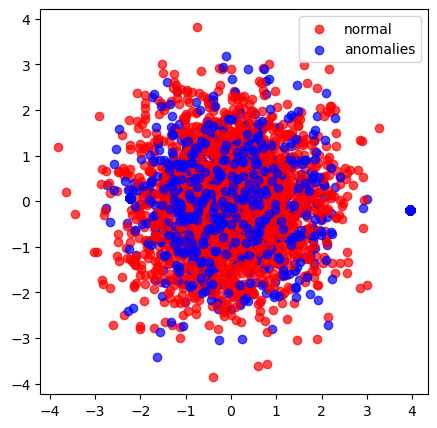

In [88]:
model.eval()
# model.train()
plot_latent(model, train_loader_at_eval, num_batches=1)

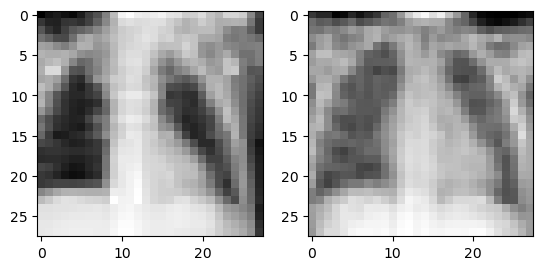

In [89]:
x, y = next(iter(train_loader))
x_0 = x[np.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[np.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0], cmap='gray')


# z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

In [90]:
x = torch.cat([x_0, x_1])
z = model.botleneck(model.encoder(x.to(device))).detach().cpu()
model.botleneck.sigma, model.botleneck.mu

(tensor([[1.0348, 1.0462],
         [1.0880, 1.0509]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor([[-0.0008,  0.0033],
         [ 0.0002,  0.0040]], device='cuda:0', grad_fn=<AddmmBackward0>))

NameError: name 'z_0' is not defined

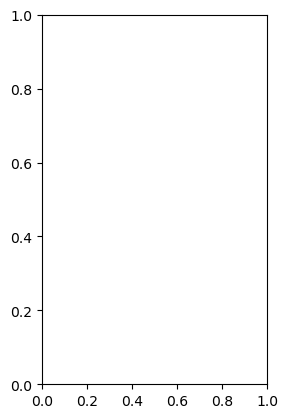

In [91]:
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

(tensor(0.0623, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0698, device='cuda:0', grad_fn=<MseLossBackward0>))

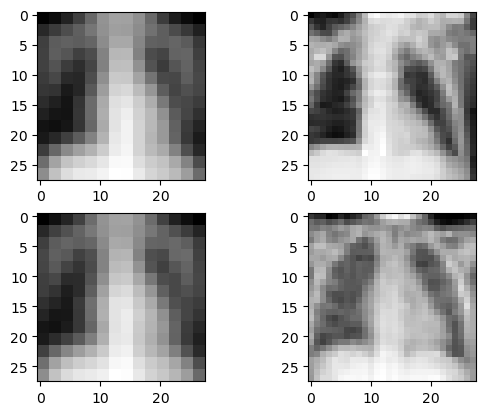

In [92]:
x_hat = model(x_0.to(device))
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1.to(device))
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

mse_loss(x_hat, x_0.to(device)), mse_loss(x_hat, x_1.to(device))

In [93]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.tanh(autoencoder.decoder(z))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

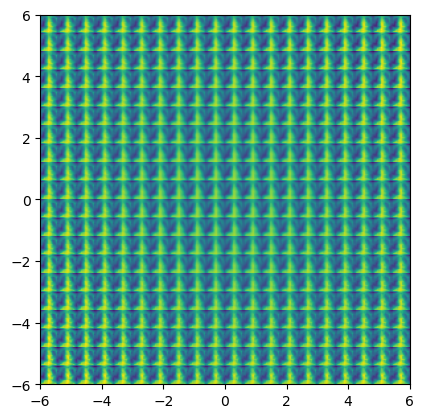

In [94]:
model.eval()
plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=20)